In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import permutation_importance
import shap

In [2]:
# Step 1: Load the Dataset
file_path = "events.csv"  # Replace with actual file path
data = pd.read_csv(file_path)

In [11]:
# Step 2: Inspect and Preprocess the Data
# Check and handle missing values
data['event_time'] = pd.to_datetime(data['event_time'])
data.fillna('Unknown', inplace=True)
data = data.drop_duplicates()

In [12]:
# Convert price column to numeric
if 'price' in data.columns:
    data['price'] = pd.to_numeric(data['price'], errors='coerce').fillna(0)

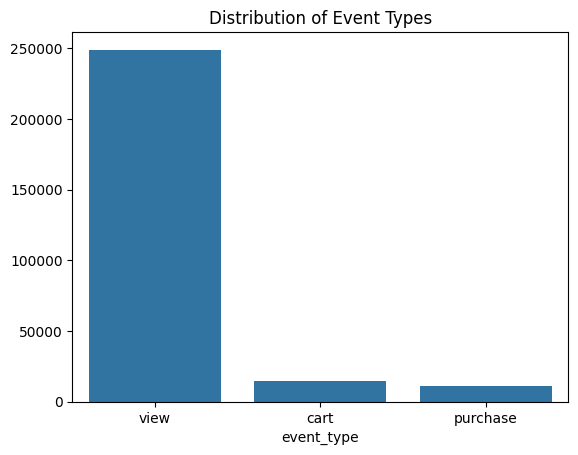

In [13]:
# Step 3: Exploratory Data Analysis (EDA)
# Distribution of event types
event_counts = data['event_type'].value_counts()
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title('Distribution of Event Types')
plt.show()

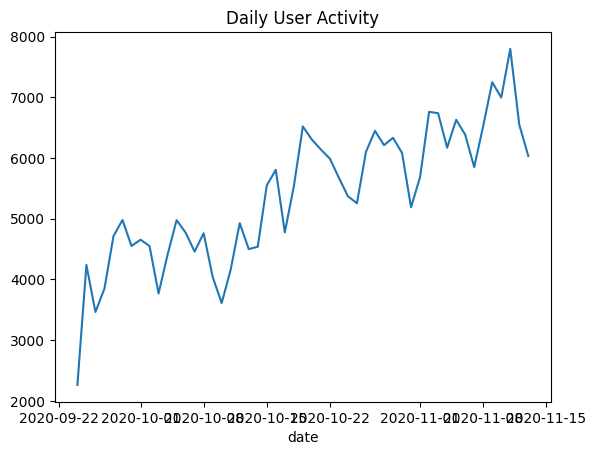

In [14]:
# User activity over time
data['date'] = data['event_time'].dt.date
daily_activity = data.groupby('date').size()
daily_activity.plot(kind='line', title='Daily User Activity')
plt.show()

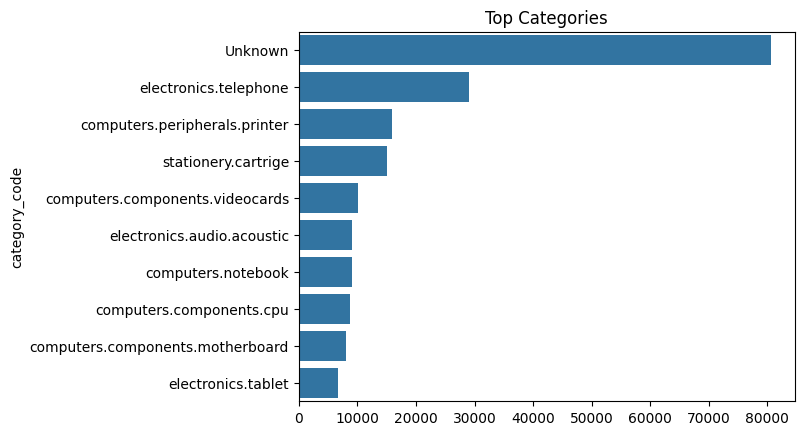

In [15]:
# Popular categories
top_categories = data['category_code'].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top Categories')
plt.show()

In [16]:
# Step 4: Define Churn
last_event = data.groupby('user_id')['event_time'].max()
churned_users = last_event[last_event < last_event.max() - pd.Timedelta(days=30)].index

In [17]:
# Step 5: Feature Engineering
features = data.groupby('user_id').agg({
    'event_time': ['max', 'min', 'count'],
    'price': 'sum'
}).reset_index()
features.columns = ['user_id', 'last_event', 'first_event', 'event_count', 'total_spent']
features['recency'] = (features['last_event'].max() - features['last_event']).dt.days
features['avg_spend'] = features['total_spent'] / features['event_count']
features['session_count'] = data.groupby('user_id')['user_session'].nunique().values
features['churned'] = features['user_id'].isin(churned_users).astype(int)

In [18]:
# Step 6: Modeling
X = features.drop(columns=['user_id', 'last_event', 'first_event', 'churned'])
y = features['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_pred_prob)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13031
           1       1.00      1.00      1.00      6987

    accuracy                           1.00     20018
   macro avg       1.00      1.00      1.00     20018
weighted avg       1.00      1.00      1.00     20018

AUC: 1.0


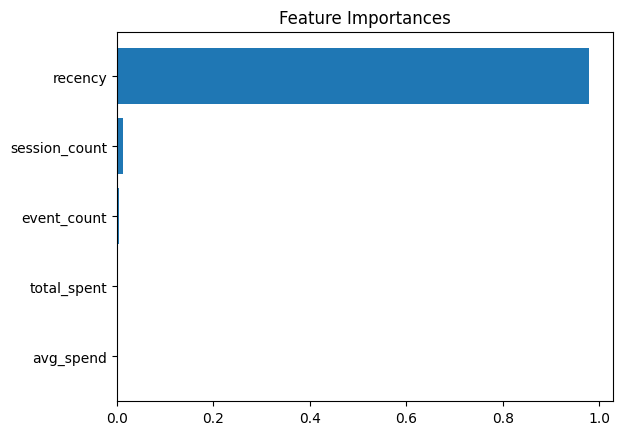

In [20]:

# Step 7: Interpretation
importances = model.feature_importances_
sorted_idx = np.argsort(importances)
plt.barh(X.columns[sorted_idx], importances[sorted_idx])
plt.title('Feature Importances')
plt.show()

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

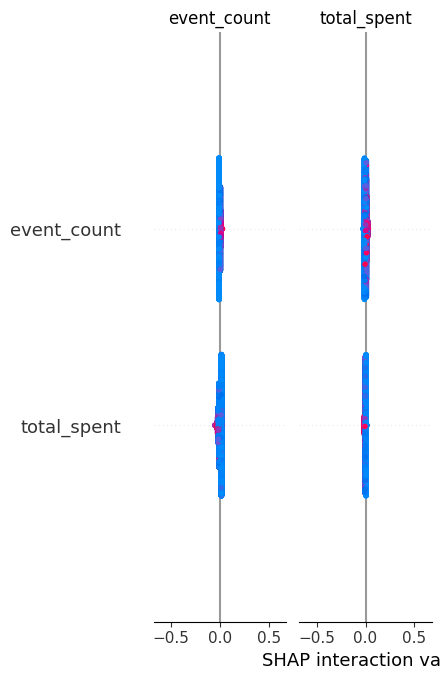

In [24]:
# Adjust SHAP value plotting for binary classification models
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test, show=True)
else:
    shap.summary_plot(shap_values, X_test, show=True)

In [25]:
# Step 8: Business Recommendations
print("Recommendations:")
print("- Focus on users with high recency and low frequency.")
print("- Offer discounts for churn-prone categories.")
print("- Provide incentives for inactive users.")

Recommendations:
- Focus on users with high recency and low frequency.
- Offer discounts for churn-prone categories.
- Provide incentives for inactive users.
